https://github.com/pytorch/examples/blob/master/mnist/main.py
https://hacks.deeplearning.jp/pytorch%E3%81%AEdataloader/

### モデル

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from collections import OrderedDict

import os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

n_shot = 1 # 使っていない

class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, n_class)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            test_loss += loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return test_loss, correct / len(test_loader.dataset)

### データセット

In [2]:
# inputs: ../omniglot_mini/images_background/Japanese_(hiragana)/
# outputs: {'image': image,'label': label} (1 image)

# check len(label)>=20 before
class OmniglotDataset(Dataset):
    def __init__(self, path_to_lang, train, train_indices, transform):

        self.data = []
        
        labels = sorted(os.listdir(path_to_lang))[:20]
        
        for label_i, label in enumerate(labels):
            path_to_label = os.path.join(path_to_lang, label)
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_indices]
            else:
                test_indices = list(set(np.arange(20)) - set(train_indices))
                chars = chars[test_indices]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)
        return [torch.from_numpy(image), torch.from_numpy(label)]

### プロットしてみる

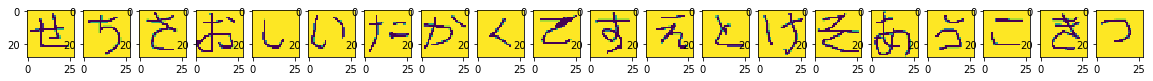

tensor([13, 16, 10,  4, 11,  1, 15,  5,  7, 18, 12,  3, 19,  8, 14,  0,  2,  9,
         6, 17])


In [3]:
batch_size = 20

local_task_train_data_loader = DataLoader(
    OmniglotDataset("../omniglot_mini/images_background/Japanese_(hiragana)/", 
                    train=True,
                    train_indices=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

for batch in local_task_train_data_loader:
    plt.figure(figsize=(20,1))
    for i, (image, label) in enumerate(zip(batch[0], batch[1])):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(image[0])
    plt.show()
    print(batch[1])

### 学習 (Omniglot_Japanese-(hiragana), 20classes, 1shot)

In [4]:
batch_size = 20 # batch_size==1だとバグる
lr = 0.01
momentum = 0.5
epochs = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

local_task_train_data_loader = DataLoader(
    OmniglotDataset("../omniglot_mini/images_background/Japanese_(hiragana)/", 
                    train=True,
                    train_indices=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

local_task_test_data_loader = DataLoader(
    OmniglotDataset("../omniglot_mini/images_background/Japanese_(hiragana)/", 
                    train=False,
                    train_indices=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=20).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

with tqdm(range(1, epochs + 1)) as _tqdm:
    for epoch in _tqdm:
        train(model, device, local_task_train_data_loader, optimizer, epoch)
        temp_loss, temp_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(step=epoch, loss=temp_loss, acc= temp_acc))

100%|██████████| 1000/1000 [00:17<00:00, 56.78it/s, step=1e+03, loss=3.96, acc=0.276]


### データセットをMNISTに変えても動きます

In [5]:
batch_size = 20 # batch_size==1だとバグる
lr = 0.01
momentum = 0.5
epochs = 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
train_loader = DataLoader(
    datasets.MNIST('../mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('../mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

with tqdm(range(1, epochs + 1)) as _tqdm:
    for epoch in _tqdm:
        train(model, device, train_loader, optimizer, epoch)
        temp_loss, temp_acc = test(model, device, test_loader)
        _tqdm.set_postfix(OrderedDict(step=epoch, loss=temp_loss, acc= temp_acc))

100%|██████████| 2/2 [00:14<00:00,  7.47s/it, step=2, loss=0.0705, acc=0.978]


### タスクセット

In [144]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return NotImplementedError

In [145]:
class OmniglotTaskset(Taskset):
    def __init__(self, path_to_omniglot, meta_train):
        
        if meta_train:
            path_to_lang = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_lang = os.path.join(path_to_omniglot, "images_evaluation/")
        
        langs = sorted(os.listdir(path_to_lang))
        tasks = [os.path.join(path_to_lang, lang) for lang in langs]
        tasks = [task for task in tasks if len(os.listdir(task))>=20]
        self.tasks = tasks
        
    def __len__(self):
        return len(self.tasks)
 
    def __getitem__(self, idx):
        train_indices=[0] #TODO 必要に応じて変える
        return {"train":
                DataLoader(
                    OmniglotDataset(self.tasks[idx], 
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotDataset(self.tasks[idx], 
                                    train=False,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

0 ../omniglot_mini/images_background/Latin


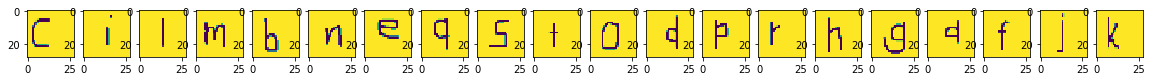

tensor([ 2,  8, 11, 12,  1, 13,  4, 16, 18, 19, 14,  3, 15, 17,  7,  6,  0,  5,
         9, 10])
1 ../omniglot_mini/images_background/Alphabet_of_the_Magi


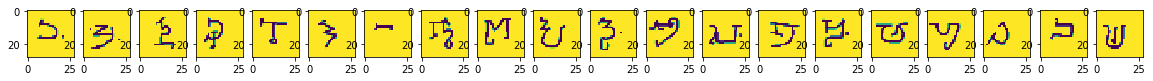

tensor([ 5,  2,  1, 12,  4, 16,  3, 11, 19, 18,  7,  8,  0, 10, 15, 13, 14,  6,
         9, 17])
2 ../omniglot_mini/images_background/N_Ko


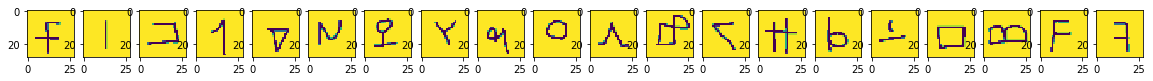

tensor([15,  0,  5, 13, 18,  4,  6,  2,  8,  1,  3, 19, 12, 16, 11,  7, 17, 14,
         9, 10])
3 ../omniglot_mini/images_background/Burmese_(Myanmar)


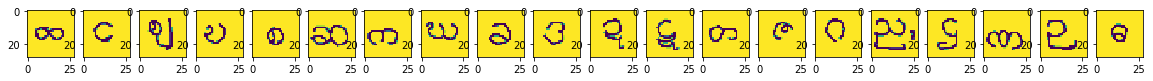

tensor([17,  4,  8, 14,  5,  6,  0,  3,  1, 18, 13, 11, 16,  7,  2,  9, 12, 15,
        10, 19])
4 ../omniglot_mini/images_background/Sanskrit


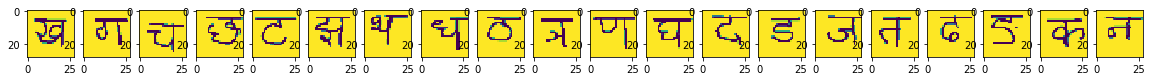

tensor([ 1,  2,  5,  6, 10,  8, 16, 18, 11,  9, 14,  3, 17, 12,  7, 15, 13,  4,
         0, 19])


In [146]:
meta_train_task_loader = TaskLoader(
    OmniglotTaskset("../omniglot_mini/", meta_train=True)
)

for task_i, meta_train_task in enumerate(meta_train_task_loader):
    print(task_i, meta_train_task["task"])
    local_task_train_data_loader = meta_train_task["train"]
    for batch in local_task_train_data_loader:
        plt.figure(figsize=(20,1))
        for i, (image, label) in enumerate(zip(batch[0], batch[1])):
            plt.subplot(1, batch_size, i+1)
            plt.imshow(image[0])
        plt.show()
        print(batch[1])
    if task_i==4:
        break

In [198]:
def train2(model, device, train_loader, optimizer, epoch, rate=1.0):
    model.train()
    
    with tqdm(train_loader) as _tqdm:
        for i, (data, target) in enumerate(_tqdm):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if i % 300 == 0:
                temp_loss, temp_acc = test(model, device, test_loader)
            _tqdm.set_postfix(OrderedDict(step=epoch, loss=temp_loss, acc= temp_acc))
            if i+1 >= len(train_loader)*rate:
                break

### モデルのコピー

### master_model

In [199]:
batch_size = 20 # batch_size==1だとバグる
lr = 0.01
momentum = 0.5
epochs = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
train_loader = DataLoader(
    datasets.MNIST('../mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('../mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

master_model = OmniglotNet(n_class=10).to(device)
master_optimizer = optim.SGD(master_model.parameters(), lr=lr, momentum=momentum)

train2(master_model, device, train_loader, master_optimizer, epoch, rate=0.5)

 49%|████▉     | 1475/3000 [00:09<00:09, 161.51it/s, step=1, loss=0.202, acc=0.937]


### 正しく学習が進んでいる

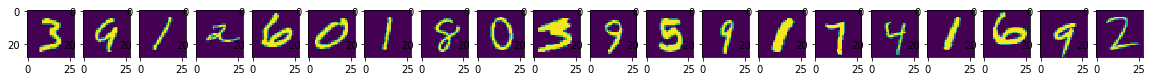

[3 9 1 2 6 0 1 8 0 3 9 5 9 1 7 4 1 6 9 2]
[3 4 1 2 6 0 1 8 0 3 9 5 9 8 7 4 1 6 4 2]


In [200]:
for batch_i, (images, labels) in enumerate(test_loader):
    plt.figure(figsize=(20,1))
    for i, image in enumerate(images):
        plt.subplot(1, len(images),i+1)
        plt.imshow(image[0])
    plt.show()
    print(labels.detach().numpy())
    y_pred = master_model(images.to(device))
    y_pred = np.argmax(y_pred.cpu().detach().numpy(), 1)
    print(y_pred)
    if batch_i==0:
        break

### faster_model

In [201]:
faster_model = OmniglotNet(n_class=10).to(device)
faster_optimizer = optim.SGD(faster_model.parameters(), lr=lr, momentum=momentum)

### 全く学習していない

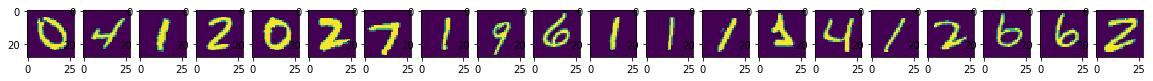

[0 4 1 2 0 2 7 1 9 6 1 1 1 1 4 1 2 6 6 2]
[1 1 1 1 2 1 2 1 2 1 1 2 1 7 1 1 1 7 1 7]


In [202]:
for batch_i, (images, labels) in enumerate(test_loader):
    plt.figure(figsize=(20,1))
    for i, image in enumerate(images):
        plt.subplot(1, len(images),i+1)
        plt.imshow(image[0])
    plt.show()
    print(labels.detach().numpy())
    y_pred = faster_model(images.to(device))
    y_pred = np.argmax(y_pred.cpu().detach().numpy(), 1)
    print(y_pred)
    if batch_i==0:
        break

### 最終層以外をコピーする

In [203]:
keys = master_model.state_dict().keys() - set(['fc2.weight', 'fc2.bias'])
params = {k: v for k, v in master_model.state_dict().items() if k in keys}
faster_model.load_state_dict(params, strict=False)

### 1epochの20%くらいの時点で95%くらい出る

In [204]:
train2(faster_model, device, train_loader, faster_optimizer, epoch, rate=0.3)

 30%|██▉       | 890/3000 [00:05<00:12, 165.38it/s, step=1, loss=0.142, acc=0.958]


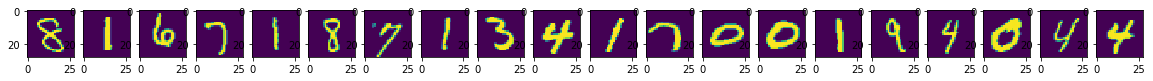

[8 1 6 7 1 8 7 1 3 4 1 7 0 0 1 9 4 0 4 4]
[8 1 6 7 1 8 7 1 3 4 1 7 0 0 1 9 9 0 4 4]


In [205]:
for batch_i, (images, labels) in enumerate(test_loader):
    plt.figure(figsize=(20,1))
    for i, image in enumerate(images):
        plt.subplot(1, len(images),i+1)
        plt.imshow(image[0])
    plt.show()
    print(labels.detach().numpy())
    y_pred = faster_model(images.to(device))
    y_pred = np.argmax(y_pred.cpu().detach().numpy(), 1)
    print(y_pred)
    if batch_i==0:
        break